# 2023-08-22__minimal_diy_ijulia_matplotlib

Both PyPlot.jl and PythonPlot.jl workflows were too slow,\
with our Sciplotlib.jl code.

So we'll have all our custom plot code in .py files.\

And directly call that, via PythonCall.jl

Hopefully this is faster.

We'll have to extract some functionality from PythonPlot.jl, for the figures to show up in an IJulia notebook.

(We don't need to bother with any GUI -- just agg i.e. static, png img display)

In [1]:
1

1

In [2]:
ENV["JULIA_CONDAPKG_BACKEND"] = "Null"
ENV["JULIA_PYTHONCALL_EXE"] = "C:\\Users\\tfiers\\mambaforge\\python";

In [3]:
@time using PythonCall

  2.046666 seconds (2.20 M allocations: 141.940 MiB, 3.40% gc time)


In [4]:
@time mpl = pyimport("matplotlib")

  1.174725 seconds (2 allocations: 80 bytes)


Python: <module 'matplotlib' from 'C:\\Users\\tfiers\\mambaforge\\Lib\\site-packages\\matplotlib\\__init__.py'>

In [5]:
@time plt = pyimport("matplotlib.pyplot")

  0.752527 seconds (3 allocations: 96 bytes)


Python: <module 'matplotlib.pyplot' from 'C:\\Users\\tfiers\\mambaforge\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [6]:
@time fig, ax = plt.subplots()

  0.550402 seconds (225.52 k allocations: 15.405 MiB)


Python: (<Figure size 640x480 with 1 Axes>, <Axes: >)

In [7]:
@time ax.plot([1,3,2])

  0.368862 seconds (554.24 k allocations: 36.645 MiB, 3.08% gc time)


Python: [<matplotlib.lines.Line2D object at 0x000001E04F66D050>]

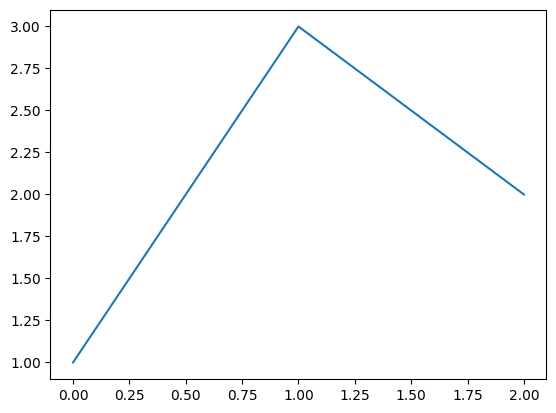

In [8]:
fig

Huh! So we don't even need any extra show/display logic, no `struct Figure` wrapper.\
Works out of the box..\
(_if_ it's last thing in cell ye).

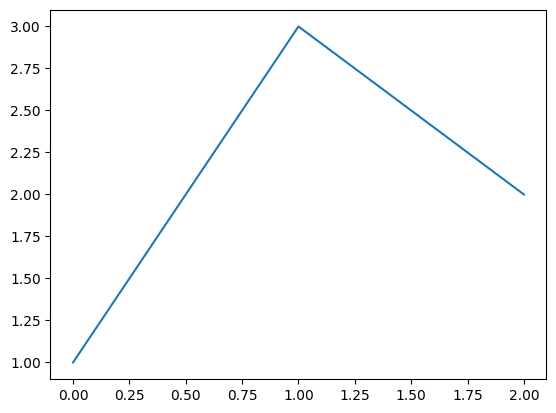

1

In [9]:
display(fig)
1

Amazing. We indeed need no wrapper. Can just add to postexec hook ye.

(It's indeed what a default python notebook does. No display calls or ending-cell-with-`fig` necessary).

Now, for our custom .py code..

In [10]:
# pyimport("./lib/plot.py")

That no work. So we used a global conda env (env vars above), and manually `pip install -e`'d our `plotlib` into it.

In [13]:
@time plotlib = pyimport("plotlib")

  0.000043 seconds (2 allocations: 32 bytes)


Python: <module 'plotlib' from 'c:\\users\\tfiers\\phd\\pkg\\plotlib\\src\\plotlib\\__init__.py'>

In [14]:
plotlib.plot([1,2,1])

Python: <Axes: >

In [17]:
Gcf = pyimport("matplotlib._pylab_helpers").Gcf

function display_figs()
    for manager in Gcf.get_all_fig_managers()
        fig = manager.canvas.figure
        if !isempty(fig.get_axes())
            display(fig)
        end
        plt.close(fig)
    end
end

function close_figs()
    for manager in Gcf.get_all_fig_managers()
        fig = manager.canvas.figure
        plt.close(fig)
    end
end

IJulia.push_postexecute_hook(display_figs)
IJulia.push_posterror_hook(close_figs);

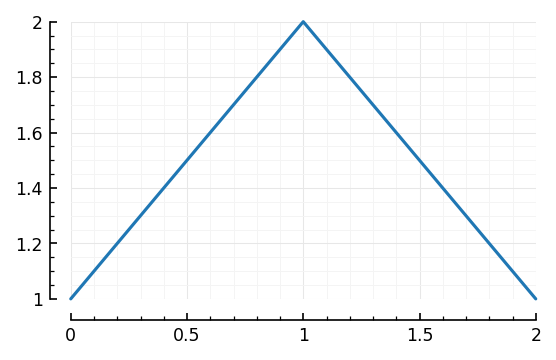

Python: <Axes: >

In [18]:
plotlib.plot([1,2,1])

😁😁😁😁😁😁😁😁

---
Deprecated (no wrapper needed):

Copying and simplifying from PythonPlot.jl:

In [8]:
@time Gcf = pyimport("matplotlib._pylab_helpers").Gcf

  0.000076 seconds (6 allocations: 152 bytes)


Python: <class 'matplotlib._pylab_helpers.Gcf'>

In [10]:
function display_figs()
    for manager in Gcf.get_all_fig_managers()
        f = manager.canvas.figure
        fig = Figure(f)
        isempty(fig) || display(fig)
        plt.close(f)
    end
end

function close_figs() # called after error in IJulia cell
    for manager in Gcf.get_all_fig_managers()
        f = manager.canvas.figure
        plt.close(f)
    end
end;

# The 'force new figs' thing seems to be kinda dead code? (Even in PyPlot.jl). So, not including.

Do we even need the 'fig' wrapper.\
Yes, cause we don't know what `io` is in `f.canvas.print_figure(io, …)`.

In [15]:
mutable struct Figure
    o::Py
end

PythonCall.Py(f::Figure) = getfield(f, :o)
PythonCall.pyconvert(::Type{Figure}, o::Py) = Figure(o)
Base.:(==)(f::Figure, g::Figure) = pyconvert(Bool, Py(f) == Py(g))
Base.isequal(f::Figure, g::Figure) = isequal(Py(f), Py(g))
Base.hash(f::Figure, h::UInt) = hash(Py(f), h)
Base.Docs.doc(f::Figure) = Base.Docs.Text(pyconvert(String, Py(f).__doc__))

# Note: using `Union{Symbol,String}` produces ambiguity.
Base.getproperty(f::Figure, s::Symbol) = getproperty(Py(f), s)
Base.getproperty(f::Figure, s::AbstractString) = getproperty(f, Symbol(s))
Base.setproperty!(f::Figure, s::Symbol, x) = setproperty!(Py(f), s, x)
Base.setproperty!(f::Figure, s::AbstractString, x) = setproperty!(f, Symbol(s), x)
Base.hasproperty(f::Figure, s::Symbol) = pyhasattr(Py(f), s)
Base.propertynames(f::Figure) = propertynames(Py(f))

Base.isempty(f::Figure) = isempty(f.get_axes())

Base.show(io::IO, m::MIME"image/png", f::Figure) =
    f.canvas.print_figure(io, format="png", bbox_inches="tight")
    # We omit the `_showable(m, f)` check.

Base.showable(m::MIME"image/png", f::Figure) = !isempty(f)
# We omit the `&& haskey(PyDict{Any,Any}(f.canvas.get_supported_filetypes()), "png")` check.

In [17]:
typeof(fig)

Py

In [18]:
(fig, ax)

(<py Figure size 640x480 with 1 Axes>, <py Axes: >)

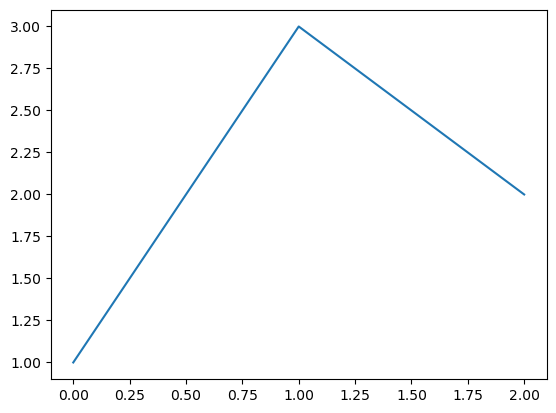

In [16]:
fig